In [1]:
from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain.agents import AgentExecutor, Tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import Graph, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

from typing_extensions import TypedDict
from typing import Dict, List, Optional, Tuple, Annotated



In [2]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [3]:
from langchain_community.llms import Ollama
llm = Ollama(
    base_url='http://localhost:11434',
    model="llama3.2"
)

/var/folders/9f/zvq77g9s0dj61sn2k6jj75hr0000gn/T/ipykernel_50276/166112536.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(


In [5]:
import json 
with open("cot.json") as f:
    cot = json.load(f)
print(cot)

{'0': {'question': 'In which environment is the system used?', 'examples': {'answers': [" Insurance Claims Processing or Risk Management or Data Analytics \nExplanation: 1. Insurance Claims Processing: The system might be used by an insurance company's claims processing department to analyze and identify patterns in healthcare insurance claims. 2. Risk Management: The system could be applied in risk management teams to detect potential risks and opportunities for cost savings. 3. Data Analytics: The system might be used by a data analytics team within the healthcare insurance company to identify patterns in claims data, helping to inform business decisions .", ' Municipal Waste Management or Private Waste Management departments \nExplanation: Waste management companies need to efficiently collect and process waste while minimizing costs and environmental impact. By using generative AI to analyze historical data on waste generation, recycling rates, and resource utilization, they can op

In [6]:
def make_prompt(use_case, query, answers=[], intents=[]):
    if len(answers) == 0:
        cot_string = f"Question: [Given: {use_case}] [Question: {query}]\n"
    else:
        assert len(answers) == len(intents), "Few shot intents and answers should be the same length"
        cot_string = "Few shot examples: "
        for index, cot_intent in enumerate(intents):
            cot_answer = answers[index]
            cot_string = cot_string + f"Example: [Given: {cot_intent}] [Question: {query}] Output: [{cot_answer}]\n"
        cot_string = cot_string + f"Question: [Given: {use_case}] [Question: {query}]\n"
    return cot_string

In [7]:
def generate_few_shot(use_case, query, answers, intents):
    print(len(answers), len(intents))
    cot_string = make_prompt(use_case, query, answers, intents)
    return cot_string

In [8]:
question = cot["2"]["question"]
cot_answers = cot["2"]["examples"]["answers"]
cot_intents = cot["2"]["examples"]["intents"]
usecase = "Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interactions with customers."

cot_intent = generate_few_shot(usecase, question, cot_answers, cot_intents)


3 3


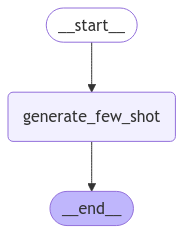

Find AI task:
Generate personalized, relevant responses, recommendations, and summaries of claims for customers to support agents to enhance their interactions with customers.

--- --- ---

AI task
Based on the examples provided, here are some common themes and observations about the techniques utilized in various systems:

1. **Natural Language Processing (NLP)**: NLP is a dominant technique across all examples, with multiple sub-techniques such as text classification, text generation, token classification, translation, zero-shot classification, feature extraction, fill mask, question answering, sentence similarity, summarization, and table question answering.
2. **Reinforcement Learning (RL)**: RL is used in two out of three examples, where it is employed to optimize the performance of generative models or to generate code snippets/dialog flows based on classified instructions.
3. **Text Generation**: Text generation techniques are used in multiple examples, such as generating report

In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    intent: str
    cot_intent: str
    ai_task: str


# Nodes
def generate_zero_shot(state: State):

    msg = llm.invoke(f"{state['intent']}")
    return {"ai_task": msg}


# Nodes
def generate_few_shot(state: State):

    msg = llm.invoke(f"{state['cot_intent']}")
    return {"ai_task": msg}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("questionnaire", generate_few_shot)

# Add edges to connect nodes
workflow.add_edge(START, "questionnaire")
workflow.add_edge("questionnaire", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"cot_intent": cot_intent, "intent":usecase})
print("Find AI task:")
print(state["intent"])
print("\n--- --- ---\n")
print("AI task")
print(state["ai_task"])
print("\n--- --- ---\n")
